In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/input/final-hs-categories/Categories.csv')
print(df.head())


              label                                  text
0  appearance-based             البدينون يستحقون الاحترام
1  appearance-based             قصار القامه مثيرون للشفقه
2  appearance-based         ذوو الوجوه القبيحه مكان بيننا
3  appearance-based  اصحاب البشره الداكنه يبدون كالمجرمين
4  appearance-based              لديه انف كبير يبدو مضحكا


In [4]:
print(df['label'].value_counts())

label
racisme             2075
identity-based      2069
religion_hate       1714
appearance-based    1689
gender_hate         1529
Name: count, dtype: int64


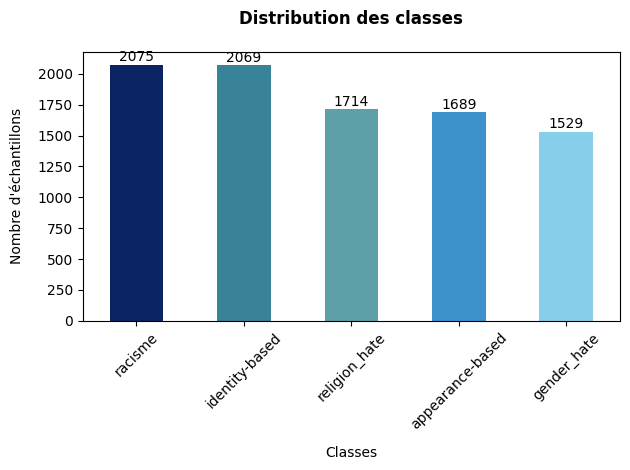

In [9]:
import matplotlib.pyplot as plt

value_counts = df["label"].value_counts()

colors = ["#0A2463", "#398399", "#5DA0A7", "#3E92CC", "#87CEEB"]
# colors = ["#0B3C5D", "#398399", "#5DA0A7", "#87CEEB", "#B7E3F9"]

value_counts.plot(kind="bar", color=colors)

plt.title("Distribution des classes", fontweight="bold", pad=20)
plt.xlabel("Classes", labelpad=10)
plt.ylabel("Nombre d'échantillons", labelpad=10)
plt.xticks(rotation=45) 

for i, count in enumerate(value_counts):
    plt.text(i, count + 5, str(count), ha="center", va="bottom")

plt.tight_layout()  
plt.show()

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score


label_mapping = {
    "racisme": 0,
    "identity-based": 1,
    "gender_hate": 2,
    "religion_hate": 3,
    "appearance-based": 4
}

df["label"] = df["label"].map(label_mapping)
df_clean = df[["text", "label"]].dropna()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_clean["text"],
    df_clean["label"],
    test_size=0.2,
    random_state=42
)

# Charger le tokenizer AraBERT
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

def tokenize_data(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=512)

train_encodings = tokenize_data(train_texts)
test_encodings = tokenize_data(test_texts)

class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Convertir en dataset PyTorch
train_dataset = HateSpeechDataset(train_encodings, train_labels.tolist())
test_dataset = HateSpeechDataset(test_encodings, test_labels.tolist())

model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02", num_labels=5)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")  
    return {
        "accuracy": acc,
        "f1": f1
    }


early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16,  
    num_train_epochs=5,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    warmup_steps=500,
    learning_rate=2e-5,
    weight_decay=0.01,
    lr_scheduler_type="linear",
   
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping] 
)

trainer.train()


2025-04-27 00:47:46.834406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745714867.117868      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745714867.183720      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.558764,0.814978,0.813654
2,No log,0.304308,0.889868,0.890180
3,0.744600,0.315759,0.895374,0.895762
4,0.744600,0.340625,0.890419,0.890866


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=908, training_loss=0.501243860185934, metrics={'train_runtime': 387.9053, 'train_samples_per_second': 93.58, 'train_steps_per_second': 2.926, 'total_flos': 1283440964287680.0, 'train_loss': 0.501243860185934, 'epoch': 4.0})

In [7]:
results = trainer.evaluate()
print("✅ Résultats de l'évaluation :", results)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Résultats de l'évaluation : {'eval_loss': 0.30430832505226135, 'eval_accuracy': 0.8898678414096917, 'eval_f1': 0.8901801702492173, 'eval_runtime': 6.3774, 'eval_samples_per_second': 284.757, 'eval_steps_per_second': 8.938, 'epoch': 4.0}


In [8]:
from sklearn.metrics import classification_report
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=-1)
                                                            
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.80      0.81       392
           1       0.81      0.88      0.84       430
           2       0.98      0.95      0.96       320
           3       0.92      0.84      0.88       338
           4       0.98      1.00      0.99       336

    accuracy                           0.89      1816
   macro avg       0.90      0.89      0.90      1816
weighted avg       0.89      0.89      0.89      1816



In [10]:
torch.save(model.state_dict(), 'Category_model.pth')

**Matrice de confusion**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


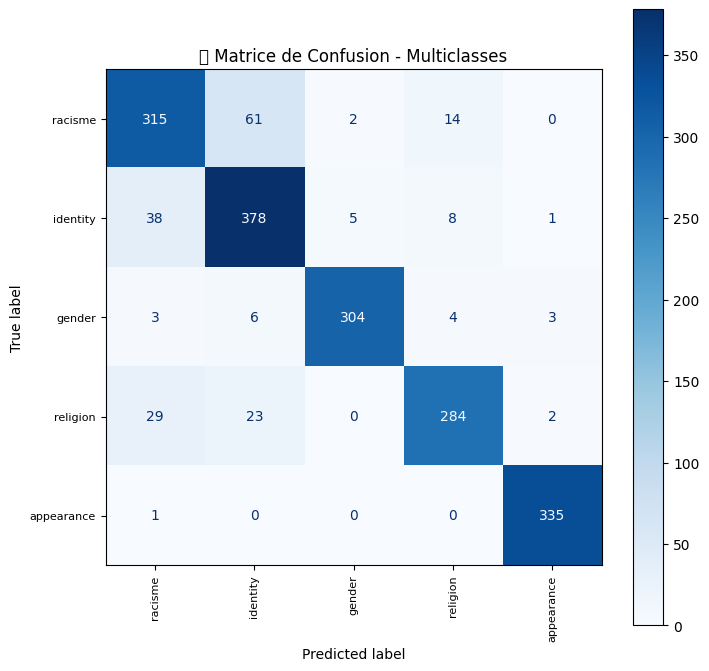

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

model.eval()

texts = test_texts.tolist()
labels = test_labels.tolist()

predictions = []

for text in texts:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).cpu().item()
    predictions.append(pred)

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["racisme", "identity", "gender", "religion", "appearance"]
)

fig, ax = plt.subplots(figsize=(8, 8))  # taille du graphique
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.title("✅ Matrice de Confusion - Multiclasses", fontsize=12)
plt.show()
